# Sentiment Analysis Starter Code
Use this code as a template, starting place, or inspiration... whatever helps you get started!

## Imports
This starter code requires the use of certain packages. You can install them via the command: `pip install seaborn nltk  beautifulsoup4 pandas sklearn tqdm numpy`

If you are using Google Colab, you do not need to do this step.

In [1]:
# Import Python Standard Library Packages
import math
import re
import os
from collections import Counter, defaultdict

# Import Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import Text Processing Packages
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Import Data Loading / ML Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize configs / constants
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Disable warnings for Beautiful Soup Package
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/n8srumsey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Downloading Data
Visit [https://www.kaggle.com/competitions/osuaiclub-fall2022-nlp-challenge/data](https://www.kaggle.com/competitions/osuaiclub-fall2022-nlp-challenge/data) to download the dataset!

## Loading Data
We will be using the `pandas` package to load in our data. All the data is conveniently stored in a `.csv` file which is really easy to construct a `pandas` dataframe out of.

In [2]:
DATA_DIR = './data/'

In [3]:
if os.path.exists(os.path.join(DATA_DIR, 'train.csv')):
    train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), index_col='id')
else:
    train_df = pd.read_csv("https://raw.githubusercontent.com/OSU-AIClub/Fall-2022/main/Kaggle%20Competition/data/train.csv")
train_df

,review,sentiment
id,,
10000,""" While sporadically engrossing (including a f...",0
10001,"A French novelist, disgusted by his wife's soc...",1
10002,"It must be remembered that the Gammera movies,...",0
10003,"I gave this film 8 out of 10, reserving 10 for...",1
10004,"Cheap, gloriously bad cheese from the 80's, th...",0
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0


# Define Tokenizer
Now that we have our data, we need to tokenize our input for the classifier to be able to process our input. Here, we are using sipmly just regex expressions, removing stop words, and normalization to tokenize and process our text. Consider adding different strategies such as stemming, lemmatization, parts of speech tagging, and named entity recognition to improve the accuracy further!

In [4]:
class Tokenizer:
  
  def clean(self, text):
      # Remove HTML Tags from input
      no_html = BeautifulSoup(text).get_text()
      
      # Replace anything that isn't a letter with a space
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      
      # Replace all whitespace with a single space
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      # Clean input text
      clean = self.clean(text).lower()
      
      # Use predefined list NLTK's English stopwords
      stopwords_en = stopwords.words("english")
      
      # Return the list of tokens (i.e. tokenized text)
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]
  

# Definte Naive-Bayes Classifier
Next, we need to define our Naive-Bayes Classifier. There are many prebuilt classifiers, but we will be creating our own "from scratch". Play around and try different ones!

In [5]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in tqdm(data):
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in tqdm(X):
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

# Define Train and Validation Partitions
Now that we have defined the tokenizer and naive-bayes classifier, we now need to load the training data and split it into separate partitions. 

In [6]:
# Get list of input and output values for each training sample
X = train_df['review'].values
y = train_df['sentiment'].values
  
# Randomly split into a training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Fit Naive-Bayes Classifier
Now that we have prepared the training data partition, we can instantiate and fit the Naive-Bayes Classifier on the training data.

In [7]:
# Initialize Model and Fit it to the Training Data
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

100%|██████████| 16034/16034 [00:07<00:00, 2120.21it/s]


## Evaluate Performance
Now that we have fit our Naive-Bayes Classifier, we can predict the sentiment on the validation dataset to get an idea of how accurate our model is!

In [8]:
# Predict sentiment on the validation dataset split
y_hat = MNB.predict(X_val)

100%|██████████| 8000/8000 [00:04<00:00, 1741.49it/s]


In [9]:
# Get accuracy on the validation split
accuracy_score(y_val, y_hat)

0.854375

In [10]:
# More performance metrics
print(classification_report(y_val, y_hat))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      4062
           1       0.82      0.90      0.86      3938

    accuracy                           0.85      8000
   macro avg       0.86      0.86      0.85      8000
weighted avg       0.86      0.85      0.85      8000



## Prdouce Confusion Matrix to  Visualize Results
To visualize our True Positive, True Negative, False Positive, and False Negative predictions, we will plot a confusion matrix using `seaborn` and `pyplot`.

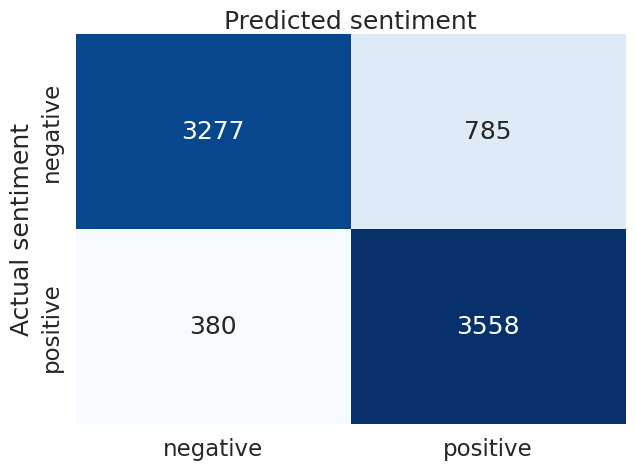

In [11]:
# Produce confusion matrix of true positives, true negatives, false postives, and false negatives
cnf_matrix = confusion_matrix(y_val, y_hat)

# Create Plot
class_names = ["negative", "positive"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');

# Inference on Test Dataset
 Our model is now trained, and we have a good accuracy of `85%`! This means we can now predict the sentiment of each sample in the test dataset and save it to a `.csv` file so we can submit it to the Kaggle competition. 

In [12]:
# Read test dataset from file or internet
if os.path.exists(os.path.join(DATA_DIR, 'test.csv')):
    train_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), index_col='id')
else:
    train_df = pd.read_csv("https://raw.githubusercontent.com/OSU-AIClub/Fall-2022/main/Kaggle%20Competition/data/test.csv")

# Get input values and predict sentiment
test_inputs = test_df['review'].values
predictions = MNB.predict(test_inputs)
submission = {'sentiment': predictions}

# Convert predictions to a Pandas Dataframe   
submission_df = pd.DataFrame(submission)
submission_df.index.name = 'id'
submission_df

NameError: name 'test_df' is not defined

In [ ]:
# Save predictions to a CSV file for submission
submission_df.to_csv('submission.csv')

# Submit Predictions
And that is it! We now have a `.csv` file containing sentiment predictions which we can now upload to get scored! Go to https://www.kaggle.com/competitions/osuaiclub-fall2022-sentiment-analysis/ and submit your prediction file.